In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

from funicular import *

In [2]:
def create_Pratt(span, panels, height):
    nodes = []
    for x in np.arange(0, span+span/panels, span/panels):
        for y in [0, height]:
            nodes.append([x, y])
    nodes = np.array(nodes)

    members = []
    for i in range(int(panels/2)):
        # Vertical member
        members.append([2*i, 2*i+1])

        # Horizontal chords
        members.append([2*i, 2*i+2])
        members.append([2*i+1, 2*i+3])

        # Diagonal member
        members.append([2*i+1, 2*i+2])

    i = int(panels/2)
    members.append([2*i, 2*i+1])  

    for i in range(int(panels/2), panels):
        # Horizontal member
        members.append([2*i, 2*i+2])
        members.append([2*i+1, 2*i+3])

        # Vertical member
        members.append([2*i+2, 2*i+3])

        # Diagonal member
        members.append([2*i, 2*i+3])
    members = np.array(members)
    
    return nodes, members

In [3]:
class Truss:
    nodes = []
    members = []
    forcenodes = []
    forces = []
    supports = []
    reactions = []
    
    
    '''
    GET THE SLOPES OF EACH MEMBER OF THE TRUSS
    '''
    def member_slopes(self):
        s = self.nodes[self.members[:, 0]]
        e = self.nodes[self.members[:, 1]]
        
        vert = np.where(s[:, 0]==e[:, 0])[0]
        
        slopes = np.zeros(len(self.members))
        
        vert = np.where(s[:, 0]==e[:, 0])[0]
        ang = np.delete(np.arange(0, len(self.members),1), vert)


        slopes[ang] = (e[ang, 1]-s[ang, 1])/(e[ang, 0]-s[ang, 0])
        for v in vert:
            # Upwards vertical
            if e[v, 1]>s[v, 1]:
                slopes[v] = np.inf
            # Downwards vertical
            else:
                slopes[v] = -np.inf

        return slopes
    
    
    '''
    PLOT THE TRUSS MEMBER GEOMETRY
    '''
    def plot_form(self, plot_force = False, m_color='b', a=1):
        
        plt.scatter(self.nodes[:, 0], self.nodes[:, 1], c='r')
        
        for m in self.members:
            s = self.nodes[m[0]]
            e = self.nodes[m[1]]
            plt.plot([s[0], e[0]], [s[1], e[1]], c=m_color, alpha=a)
            
            
        if plot_force:
            plt.scatter(self.nodes[self.forcenodes, 0], self.nodes[self.forcenodes, 1], color='c')
            plt.scatter(self.nodes[self.supports, 0], self.nodes[self.supports, 1], color='c')
            
            
    '''
    GET REACTION
    '''
    def get_reactions(self):
        # Create funicular form for the forces
        poly = funicular_polygon()
        poly.set_loads(self.forces)
        poly.origin = np.mean(poly.load_line, axis=0)-np.array([2, -1])

        # Get the form 
        X = np.concatenate((np.concatenate((np.zeros(1), self.nodes[self.forcenodes, 0])), np.array([np.max(self.nodes[:, 0])])))
        poly.get_geometry(X)
        slope = (poly.Y[-1]-poly.Y[0])/(poly.X[-1]-poly.X[0])
        R = poly.load_line_intersect(poly.origin, slope)
        
        R1 = poly.load_line[0] - R
        R2 = R - poly.load_line[-1]
        
        self.reactions = np.array([R1, R2])

In [4]:
# Create truss geometry
span = 10
panels = 4
height = span/panels

nodes, members = create_Pratt(span, panels, height)
    
fmag = 2
fnodes = np.arange(3, (panels-1)*2+1+2, 2)
forces = np.zeros((len(fnodes), 2))
forces[:, 1] = -fmag

(-0.608617245410516,
 10.608617245410516,
 -0.16758773752213824,
 2.66721494904015)

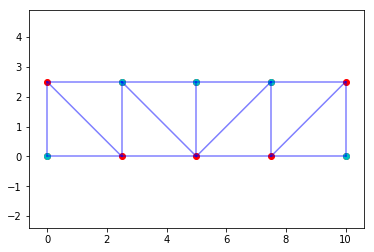

In [5]:
truss = Truss()
truss.nodes = nodes
truss.members = members
truss.forcenodes = fnodes.astype('int')
truss.forces = forces
truss.supports = np.array([0, (panels)*2])
truss.reactions = np.array([[0, -np.sum(truss.forces[:, 1])/2], [0, -np.sum(truss.forces[:, 1])/2]])

truss.plot_form(a=0.5, plot_force=True)
plt.axis('equal')